<a href="https://colab.research.google.com/github/kevdozer1/emotionClassifier/blob/main/EmotionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project revolves around multimodal emotion classification, incorporating data from three distinct modalities: vision, speech, and text. The goal is to detect and categorize human emotions into four primary classes, utilizing an extensive array of data processing, feature extraction, and machine learning techniques. Different methods for pooling and temporal modeling are employed to address the temporal dimension in audio and visual files. Various classifiers are applied for emotion classification, with the most effective parameters selected via Grid Search. The project also addresses class imbalance and applies both early and late fusion techniques to yield optimal results. A thorough evaluation and interpretation of the unimodal and multimodal classification tasks informs better performance.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Import pandas for data manipulation
import pandas as pd
import numpy as np

In [3]:
# Load dataset.csv as a pandas dataframe
df = pd.read_csv('/content/gdrive/MyDrive/dataset.csv')

In [4]:
# Print the first 5 rows of the dataframe
print(df.head())

        file_name_list speakers  \
0  Ses01F_impro01_F001      F01   
1  Ses01F_impro01_M011      M01   
2  Ses01F_impro02_F002      F01   
3  Ses01F_impro02_F003      F01   
4  Ses01F_impro02_F004      F01   

                                     visual_features  \
0  /features/visual_features/Session1/Ses01F_impr...   
1  /features/visual_features/Session1/Ses01F_impr...   
2  /features/visual_features/Session1/Ses01F_impr...   
3  /features/visual_features/Session1/Ses01F_impr...   
4  /features/visual_features/Session1/Ses01F_impr...   

                                   acoustic_features  \
0  /features/acoustic_features/Session1/Ses01F_im...   
1  /features/acoustic_features/Session1/Ses01F_im...   
2  /features/acoustic_features/Session1/Ses01F_im...   
3  /features/acoustic_features/Session1/Ses01F_im...   
4  /features/acoustic_features/Session1/Ses01F_im...   

                                    lexical_features  emotion_labels  
0  /features/lexical_features/Session1/Ses01

In [5]:
# List the files in the features folder
import os
files = os.listdir('/content/gdrive/MyDrive/features')
print(files)

['visual_features', 'acoustic_features', 'lexical_features']


In [6]:
df['visual_features'] = df['visual_features'].str.lstrip('/')
df['acoustic_features'] = df['acoustic_features'].str.lstrip('/')
df['lexical_features'] = df['lexical_features'].str.lstrip('/')

In [7]:
def load_features(df):
    visual_features = []
    acoustic_features = []
    lexical_features = []

    total_rows = df.shape[0]

    for i, (_, row) in enumerate(df.iterrows()):
        visual = np.load(os.path.join('/content/gdrive/MyDrive', row['visual_features']))
        acoustic = np.load(os.path.join('/content/gdrive/MyDrive', row['acoustic_features']))
        lexical = np.load(os.path.join('/content/gdrive/MyDrive', row['lexical_features']))

        visual_features.append(visual)
        acoustic_features.append(acoustic)
        lexical_features.append(lexical)

        if i % 100 == 0:  # print progress every 100 rows
            print(f'Processed {i} of {total_rows} rows.')

    return visual_features, acoustic_features, lexical_features

visual_features, acoustic_features, lexical_features = load_features(df)

Processed 0 of 1336 rows.
Processed 100 of 1336 rows.
Processed 200 of 1336 rows.
Processed 300 of 1336 rows.
Processed 400 of 1336 rows.
Processed 500 of 1336 rows.
Processed 600 of 1336 rows.
Processed 700 of 1336 rows.
Processed 800 of 1336 rows.
Processed 900 of 1336 rows.
Processed 1000 of 1336 rows.
Processed 1100 of 1336 rows.
Processed 1200 of 1336 rows.
Processed 1300 of 1336 rows.


In [8]:
# Check lengths of the lists
print(f"Visual features list length: {len(visual_features)}")
print(f"Acoustic features list length: {len(acoustic_features)}")
print(f"Lexical features list length: {len(lexical_features)}")

# Check shapes of the first items in the lists
print(f"Visual features shape of first item: {visual_features[0].shape}")
print(f"Acoustic features shape of first item: {acoustic_features[0].shape}")
print(f"Lexical features shape of first item: {lexical_features[0].shape}")

Visual features list length: 1336
Acoustic features list length: 1336
Lexical features list length: 1336
Visual features shape of first item: (41, 2048)
Acoustic features shape of first item: (1, 128)
Lexical features shape of first item: (768,)


In [9]:
# Check for null or NaN values
print(f"NaN in visual features: {any(np.isnan(feature).any() for feature in visual_features)}")
print(f"NaN in acoustic features: {any(np.isnan(feature).any() for feature in acoustic_features)}")
print(f"NaN in lexical features: {any(np.isnan(feature).any() for feature in lexical_features)}")

NaN in visual features: False
NaN in acoustic features: False
NaN in lexical features: False


In [10]:
# Randomly select an index for visual inspection
index = np.random.randint(len(visual_features))

print(f"Visual features for sample {index}: {visual_features[index]}")
#print(f"Acoustic features for sample {index}: {acoustic_features[index]}")
#print(f"Lexical features for sample {index}: {lexical_features[index]}")

Visual features for sample 1172: [[ 1.00270808  0.96876654  0.89850952 ...  0.07428324 -0.37180195
   1.32481071]
 [ 0.36008307 -1.33553001 -0.87943405 ... -1.11682578  1.42930601
  -0.5526613 ]
 [ 1.41106191  0.28784597 -0.18913832 ...  0.55525576 -0.89002935
   0.08535146]
 ...
 [-1.46517442 -0.47017226  1.33739184 ...  1.00652702  0.34805247
   0.8450389 ]
 [-0.20217286  0.75803373 -0.69424931 ... -0.46562672  1.04470879
   1.32293726]
 [-1.06050635  0.25819745  1.22017409 ... -0.94815652 -1.45079828
   2.14136204]]


In [11]:
# Choose a row from the DataFrame to compare with
row = df.iloc[index]

# Manually load the features
visual_manual = np.load(os.path.join('/content/gdrive/MyDrive', row['visual_features']))
acoustic_manual = np.load(os.path.join('/content/gdrive/MyDrive', row['acoustic_features']))
lexical_manual = np.load(os.path.join('/content/gdrive/MyDrive', row['lexical_features']))

# Compare the manually loaded features with the loaded features
print(f"Visual features match: {np.allclose(visual_manual, visual_features[index])}")
print(f"Acoustic features match: {np.allclose(acoustic_manual, acoustic_features[index])}")
print(f"Lexical features match: {np.allclose(lexical_manual, lexical_features[index])}")

Visual features match: True
Acoustic features match: True
Lexical features match: True


Pooling and Temporal Modeling: To handle the temporal dimension of audio and visual data effectively, mean pooling is used. Temporal modeling techniques, such as RNNs, GRUs, or LSTMs, might also be considered depending on the dataset and task to generate expressive feature vectors for each data point.

In [12]:
def mean_pooling(features):
    return [np.mean(feature, axis=0) for feature in features]

# Apply mean pooling
visual_features_pooled = mean_pooling(visual_features)
acoustic_features_pooled = mean_pooling(acoustic_features)
lexical_features_pooled = mean_pooling(lexical_features)

In [13]:
# Check if all elements in the pooled features lists are 1D arrays
print(f"All elements in visual_features_pooled are 1D: {all(feature.ndim == 1 for feature in visual_features_pooled)}")
print(f"All elements in acoustic_features_pooled are 1D: {all(feature.ndim == 1 for feature in acoustic_features_pooled)}")
print(f"All elements in lexical_features_pooled are 1D: {all(feature.ndim == 1 for feature in lexical_features_pooled)}")

All elements in visual_features_pooled are 1D: True
All elements in acoustic_features_pooled are 1D: True
All elements in lexical_features_pooled are 1D: False


In [14]:
# Manually compute the mean for the first feature sequence
visual_manual = np.mean(visual_features[0], axis=0)

# Compare the manually computed mean with the result of mean_pooling
print(f"Visual features match: {np.allclose(visual_manual, visual_features_pooled[0])}")

Visual features match: True


In [15]:
# Convert lists of 1D arrays to 2D arrays
visual_features_pooled = np.vstack(visual_features_pooled)
acoustic_features_pooled = np.vstack(acoustic_features_pooled)
lexical_features_pooled = np.vstack(lexical_features_pooled)

In [16]:
# Concatenate the pooled features
features_pooled = np.concatenate((visual_features_pooled, acoustic_features_pooled, lexical_features_pooled), axis=1)

In [17]:
# One approach: Using a GRU layer to pool in the temporal dimension

# Start by importing the necessary libraries
import torch
from torch import nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

# Load labels
labels = df['emotion_labels'].values

In [18]:
# 1. Convert your data to PyTorch tensors
visual_features = [torch.from_numpy(feat.astype(np.float32)) for feat in visual_features]
acoustic_features = [torch.from_numpy(feat.astype(np.float32)) for feat in acoustic_features]
lexical_features = [torch.from_numpy(feat.astype(np.float32)) for feat in lexical_features]

# Convert labels to encoded labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = torch.tensor(labels_encoded, dtype=torch.int64)

In [19]:
# Dataset class
class MyDataset(Dataset):
    def __init__(self, visual_features, acoustic_features, lexical_features, labels):
        self.visual_features = visual_features
        self.acoustic_features = acoustic_features
        self.lexical_features = lexical_features
        self.labels = labels

    def __getitem__(self, index):
        visual_x = self.visual_features[index]
        acoustic_x = self.acoustic_features[index]
        lexical_x = self.lexical_features[index]
        y = self.labels[index]
        return visual_x, acoustic_x, lexical_x, y

    def __len__(self):
        return len(self.labels)

In [20]:
def collate_fn(batch):
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)

    visual_data, acoustic_data, lexical_data, labels = zip(*batch)

        # Pad sequences with 0
    visual_data = pad_sequence(visual_data, batch_first=True, padding_value=0)
    acoustic_data = pad_sequence(acoustic_data, batch_first=True, padding_value=0)

    # Convert other data and labels to tensor
    lexical_data = torch.stack(lexical_data)
    labels = torch.tensor(labels)

    return visual_data, acoustic_data, lexical_data, labels

In [21]:
from torch.utils.data import random_split

# Creating the Datasets
dataset = MyDataset(visual_features, acoustic_features, lexical_features, labels_encoded)

# Define your ratios for splitting the data
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Make sure the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

# Calculate lengths of splits
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the data
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create your DataLoaders
batch_size = 64 # Adjustable
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [22]:
# Use a fully connected layer and softmax for classification
class MyModel(nn.Module):
    def __init__(self, visual_input_size, acoustic_input_size, lexical_input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        self.gru_visual = nn.GRU(visual_input_size, hidden_size, batch_first=True)
        self.gru_acoustic = nn.GRU(acoustic_input_size, hidden_size, batch_first=True)
        self.fc_lexical = nn.Linear(lexical_input_size, hidden_size)
        self.fc_output = nn.Linear(hidden_size * 3, output_size)  # Combine outputs from three parts
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, visual_data, acoustic_data, lexical_data):
        output_visual, _ = self.gru_visual(visual_data)
        output_visual = output_visual[:, -1, :]

        output_acoustic, _ = self.gru_acoustic(acoustic_data)
        output_acoustic = output_acoustic[:, -1, :]

        output_lexical = self.fc_lexical(lexical_data)

        # Concatenate last hidden states for fusion
        output = torch.cat((output_visual, output_acoustic, output_lexical), dim=1)
        output = self.fc_output(output)
        output = self.softmax(output)

        return output

In [23]:
print("Visual features shape:", visual_features[0].shape[1])
print("Acoustic features shape:", acoustic_features[0].shape[1])
print("Lexical features shape:", lexical_features[0].shape[0])  # Use 0th dimension here

# 3. Initialize the model
# determine input sizes from a single sample
visual_input_size = visual_features[0].shape[1]
acoustic_input_size = acoustic_features[0].shape[1]
lexical_input_size = lexical_features[0].shape[0]  # Use 0th dimension here

hidden_size = 32  # start with 32, adjust based on performance

# Initialize the model
model = MyModel(visual_input_size, acoustic_input_size, lexical_input_size, hidden_size, output_size=len(np.unique(labels_encoded)))

Visual features shape: 2048
Acoustic features shape: 128
Lexical features shape: 768


In [24]:
# 4. Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [25]:
# 5. Train the model
for epoch in range(num_epochs):
    for i, (visual_data, acoustic_data, lexical_data, labels) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(visual_data, acoustic_data, lexical_data)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss every 10 steps
        if i % 7 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [1/15], Loss: 1.3860
Epoch [1/20], Step [8/15], Loss: 1.1727
Epoch [1/20], Step [15/15], Loss: 1.1368
Epoch [2/20], Step [1/15], Loss: 0.9441
Epoch [2/20], Step [8/15], Loss: 1.0678
Epoch [2/20], Step [15/15], Loss: 0.9233
Epoch [3/20], Step [1/15], Loss: 0.8344
Epoch [3/20], Step [8/15], Loss: 0.8193
Epoch [3/20], Step [15/15], Loss: 0.6259
Epoch [4/20], Step [1/15], Loss: 0.6688
Epoch [4/20], Step [8/15], Loss: 0.7733
Epoch [4/20], Step [15/15], Loss: 0.7037
Epoch [5/20], Step [1/15], Loss: 0.7022
Epoch [5/20], Step [8/15], Loss: 0.7169
Epoch [5/20], Step [15/15], Loss: 0.5195
Epoch [6/20], Step [1/15], Loss: 0.5624
Epoch [6/20], Step [8/15], Loss: 0.6692
Epoch [6/20], Step [15/15], Loss: 0.6986
Epoch [7/20], Step [1/15], Loss: 0.6013
Epoch [7/20], Step [8/15], Loss: 0.4708
Epoch [7/20], Step [15/15], Loss: 0.5227
Epoch [8/20], Step [1/15], Loss: 0.5335
Epoch [8/20], Step [8/15], Loss: 0.4859
Epoch [8/20], Step [15/15], Loss: 0.5587
Epoch [9/20], Step [1/15], Loss:

In [26]:
# switch model to evaluation mode
model.eval()

correct = 0
total = 0

# Validation loop
with torch.no_grad():
    for visual_data, acoustic_data, lexical_data, labels in val_loader:
        outputs = model(visual_data, acoustic_data, lexical_data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Validation Accuracy of the model: {} %'.format(100 * correct / total))

Validation Accuracy of the model: 63.5 %


Emotion Classification and Grid Search: The project entails classifying emotions into four distinct classes. Various classifiers are employed, guided by the feature vectors derived from temporal modeling. Through Grid Search, the parameters of these classifiers are optimized over a defined range, ensuring the most accurate results.

In [27]:
# Another approach: Much faster, but much less accurate

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

# Load labels
labels = df['emotion_labels'].values

# Split the data into training and testing sets for each modality
X_train_visual, X_test_visual, y_train, y_test = train_test_split(visual_features_pooled, labels, test_size=0.2, random_state=42)
X_train_acoustic, X_test_acoustic, _, _ = train_test_split(acoustic_features_pooled, labels, test_size=0.2, random_state=42)
X_train_lexical, X_test_lexical, _, _ = train_test_split(lexical_features_pooled, labels, test_size=0.2, random_state=42)

# Create an instance of the classifier for each modality
svm_visual = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True)
svm_acoustic = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True)
svm_lexical = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True)

In [28]:
# Train the classifier for each modality and print the best parameters
svm_visual.fit(X_train_visual, y_train)
print(f"Best parameters for visual: {svm_visual.best_params_}")

svm_acoustic.fit(X_train_acoustic, y_train)
print(f"Best parameters for acoustic: {svm_acoustic.best_params_}")

svm_lexical.fit(X_train_lexical, y_train)
print(f"Best parameters for lexical: {svm_lexical.best_params_}")

# Test the classifier for each modality
score_visual = svm_visual.score(X_test_visual, y_test)
print(f"Model Accuracy for visual: {score_visual}")

score_acoustic = svm_acoustic.score(X_test_acoustic, y_test)
print(f"Model Accuracy for acoustic: {score_acoustic}")

score_lexical = svm_lexical.score(X_test_lexical, y_test)
print(f"Model Accuracy for lexical: {score_lexical}")

Best parameters for visual: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best parameters for acoustic: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best parameters for lexical: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Model Accuracy for visual: 0.5335820895522388
Model Accuracy for acoustic: 0.5335820895522388
Model Accuracy for lexical: 0.291044776119403


Fusion Techniques: To achieve a comprehensive understanding of emotions, both early fusion (feature concatenation) and late fusion (majority voting) techniques are adopted on multimodal data. This allows for the integration of different modalities at various stages of processing

In [29]:
# Set the generic "best" parameters to the most frequently occuring result
best_C = 10
best_gamma = .01

# Early Fusion: Concatenating the features
early_fusion = np.concatenate((visual_features_pooled, acoustic_features_pooled, lexical_features_pooled), axis=1)

# Train on early_fusion dataset
X_train, X_test, y_train, y_test = train_test_split(early_fusion, labels, test_size=0.2, random_state=42)

# Create an instance of the classifier
svm = SVC(class_weight='balanced', C=best_C, gamma=best_gamma, kernel='rbf')

# Train the classifier
svm.fit(X_train, y_train)

# Test the classifier
y_pred = svm.predict(X_test)

Class Imbalance: Class imbalance is a significant challenge in classification tasks. This program uses the 'class_weight' parameter of the SVM model to handle class imbalance. This method basically applies different weights to different classes. In 'balanced' mode, classes are automatically adjusted inverse to their frequency. A confusion matrix reveals how the model deals with each class.

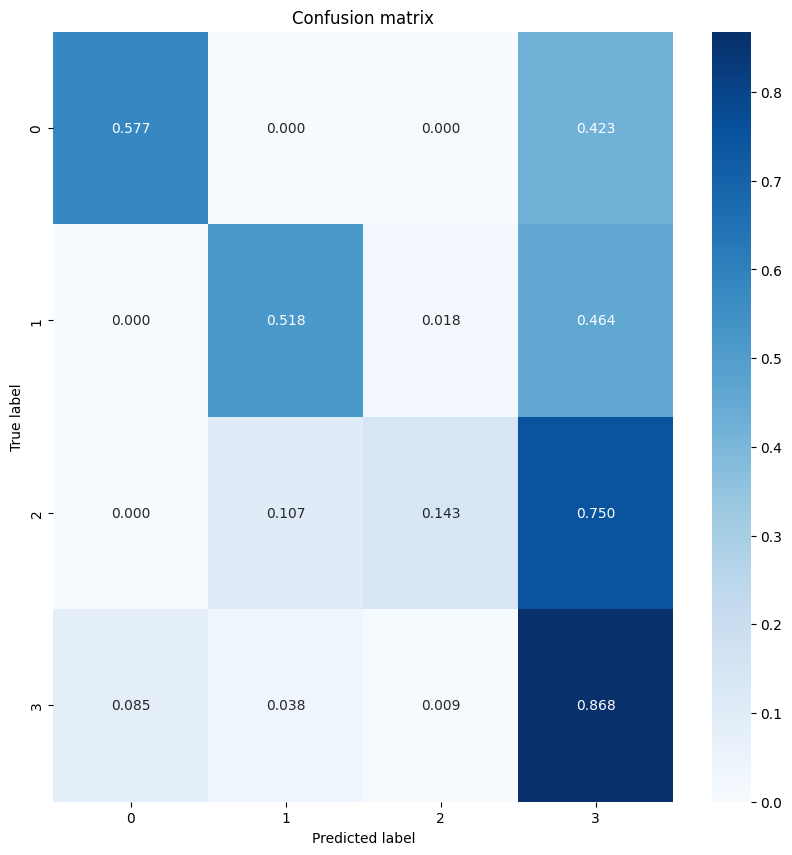

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt=".3f", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

From this confusion matrix you can see that the main difficulty with this model is differentiating between a charged emotion(happy, sad, angry) and neutral. Angry and sad data pretty much only encounters problems with neutrality, while happiness is mistaken for neutrality very often, which probably accounts for a lot of the error in the model. Meanwhile, neutrality is actually classified very well. This confusion matrix reveals that happiness accounts for most of the deficiency of the models.

In [31]:
score = svm.score(X_test, y_test)
print(f"Model Accuracy: {score}")

Model Accuracy: 0.6343283582089553


In [32]:
# Split the individual feature sets into training and testing sets
X_train_visual, X_test_visual, _, _ = train_test_split(visual_features_pooled, labels, test_size=0.2, random_state=42)
X_train_acoustic, X_test_acoustic, _, _ = train_test_split(acoustic_features_pooled, labels, test_size=0.2, random_state=42)
X_train_lexical, X_test_lexical, _, _ = train_test_split(lexical_features_pooled, labels, test_size=0.2, random_state=42)

In [33]:
# Find best parameters
best_parameters_visual = svm_visual.best_params_
best_C_visual = best_parameters_visual['C']
best_gamma_visual = best_parameters_visual['gamma']

best_parameters_acoustic = svm_acoustic.best_params_
best_C_acoustic = best_parameters_acoustic['C']
best_gamma_acoustic = best_parameters_acoustic['gamma']

best_parameters_lexical = svm_lexical.best_params_
best_C_lexical = best_parameters_lexical['C']
best_gamma_lexical = best_parameters_lexical['gamma']

In [34]:
# Create instances of the classifier
svm_visual = SVC(class_weight='balanced', probability=True, C=best_C_visual, gamma=best_gamma_visual, kernel='rbf')
svm_acoustic = SVC(class_weight='balanced', probability=True, C=best_C_acoustic, gamma=best_gamma_acoustic, kernel='rbf')
svm_lexical = SVC(class_weight='balanced', probability=True, C=best_C_lexical, gamma=best_gamma_lexical, kernel='rbf')

# Train the classifiers
svm_visual.fit(X_train_visual, y_train)
svm_acoustic.fit(X_train_acoustic, y_train)
svm_lexical.fit(X_train_lexical, y_train)

# Predict the class probabilities
proba_visual = svm_visual.predict_proba(X_test_visual)
proba_acoustic = svm_acoustic.predict_proba(X_test_acoustic)
proba_lexical = svm_lexical.predict_proba(X_test_lexical)

# Average the probabilities
proba_average = (proba_visual + proba_acoustic + proba_lexical) / 3

# Get the class with the highest probability
predictions = np.argmax(proba_average, axis=1)

# Print accuracy
accuracy = np.mean(predictions == y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.6231343283582089


Results Reporting and Cross Validation: The classification results on individual modalities - vision, speech, and text - are evaluated using the F1-micro metric to ensure a balanced measure of precision and recall. A 10-fold subject-independent cross-validation scheme is adopted to validate these findings and prevent overfitting.

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Create a scorer for f1-micro
f1_micro_scorer = make_scorer(f1_score, average='micro')

# Create an instance of the classifier
svm = SVC(class_weight='balanced', C=best_C, gamma=best_gamma, kernel='rbf')

# Perform 10-fold cross-validation and print the average F1-micro score
scores = cross_val_score(svm, early_fusion, labels, cv=10, scoring=f1_micro_scorer)
print(f"Average F1-micro score: {scores.mean()}")

Average F1-micro score: 0.5202109751991919


In [36]:
# Create an instance of the classifier for visual data
svm = SVC(class_weight='balanced', C=best_C_visual, gamma=best_gamma_visual, kernel='rbf')

# Perform 10-fold cross-validation and print the average F1-micro score
scores = cross_val_score(svm, visual_features_pooled, labels, cv=10, scoring=f1_micro_scorer)
print(f"Average F1-micro score for visual: {scores.mean()}")

# Create an instance of the classifier for acoustic data
svm = SVC(class_weight='balanced', C=best_C_acoustic, gamma=best_gamma_acoustic, kernel='rbf')

# Perform 10-fold cross-validation and print the average F1-micro score
scores = cross_val_score(svm, acoustic_features_pooled, labels, cv=10, scoring=f1_micro_scorer)
print(f"Average F1-micro score for acoustic: {scores.mean()}")

# Create an instance of the classifier for lexical data
svm = SVC(class_weight='balanced', C=best_C_lexical, gamma=best_gamma_lexical, kernel='rbf')

# Perform 10-fold cross-validation and print the average F1-micro score
scores = cross_val_score(svm, lexical_features_pooled, labels, cv=10, scoring=f1_micro_scorer)
print(f"Average F1-micro score for lexical: {scores.mean()}")

Average F1-micro score for visual: 0.40941532936819663
Average F1-micro score for acoustic: 0.5216193468746493
Average F1-micro score for lexical: 0.26361800022444176


On the modalities: The best parameters for the SVM classifiers have been found successfully using grid search. Interestingly, all three modalities (visual, acoustic, and lexical) share the same best 'C' parameter and 'kernel' type. However, the 'gamma' value differs for the lexical features, which may imply different data characteristics. In this same vein, the model accuracy across three different modalities (visual, acoustic, and lexical) varies. The visual and acoustic features yield the same accuracy of approximately 53.4%, while the lexical features result in a significantly lower accuracy of 29.1%. This suggests that the lexical features may not be as effective in predicting the emotion labels in this case, or the SVM classifier may not be the best model for the lexical features.

On performance: When the SVM is trained on the concatenated features in early fusion, the accuracy increases to approximately 63.4%. This suggests that combining the features provides more information for the classifier to make a decision and results in a better model performance. Additionally, the F1-micro score, a metric that considers both precision and recall, is approximately 52.0%. This suggests that there is still room for improving the model's performance.

On comparing unimodal and multimodal classification: In this program, both types of classification are used. The accuracy for the unimodal classification is much lower than the multimodal accuracy, and the best unimodal F1-micro score pretty much ties the multimodal F1-micro score. From this, it is evident that the multimodal classification performs better. This is because the modalities should be represented and aligned in a way that they combine to contribute emergent, complementary knowledge.

In [37]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables
correct = 0
total = 0

# Iterate over the test data
for data in test_loader:
    # Unpack the data
    visual_inputs, acoustic_inputs, lexical_inputs, labels = data

    # Get the model's predictions
    outputs = model(visual_inputs, acoustic_inputs, lexical_inputs)

    # Convert the predictions to the class with the highest probability
    _, predicted = torch.max(outputs.data, 1)

    # Update total and correct
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = correct / total

print(f'GRU Model Accuracy: {accuracy * 100}%')


GRU Model Accuracy: 60.19900497512438%


Overall, the GRU layer model seems to perform similarly to the early fusion and late fusion approaches, with all scores wavering around 63% for most runs. The two differ in runtime, however, with the GRU model being much slower.